### Load ABF Files

In [1]:
import pyabf
import slopeTools
import abfTools
import plotTools
import statsTools
import numpy as np

abfFilePaths = [
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804007.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804024.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804030.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804043.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804048.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804060.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804066.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805008.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805029.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805035.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811021.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20817012.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831017.abf"
]


### Get Holding Current and Break Data into Segments

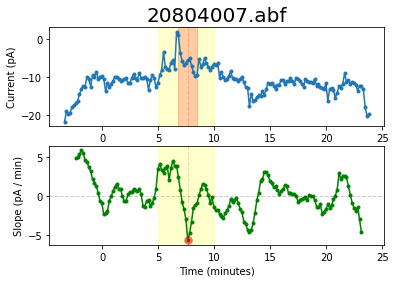

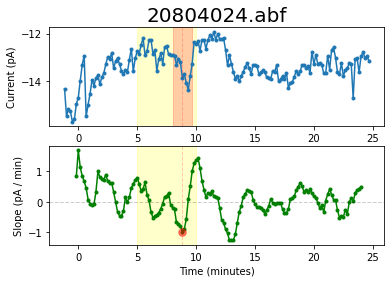

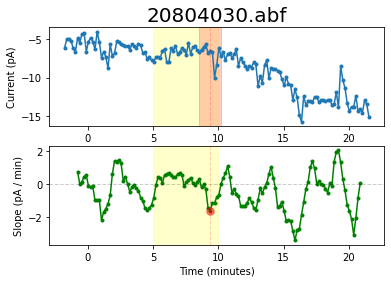

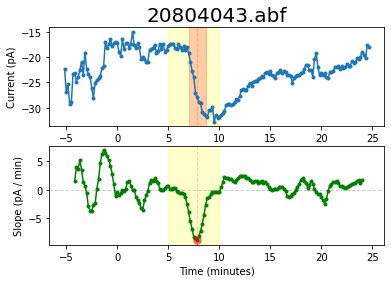

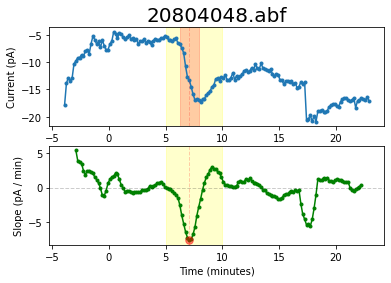

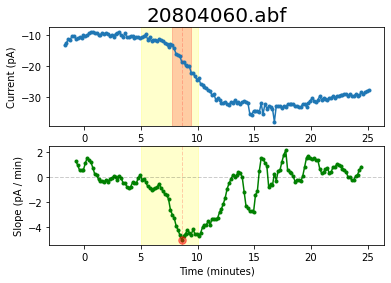

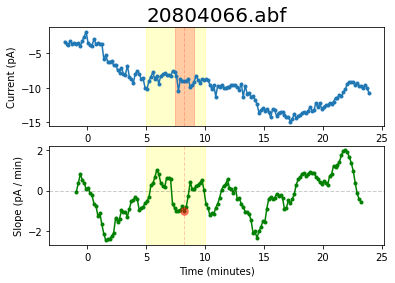

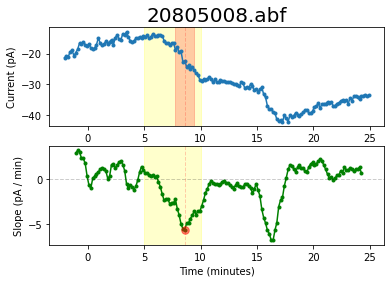

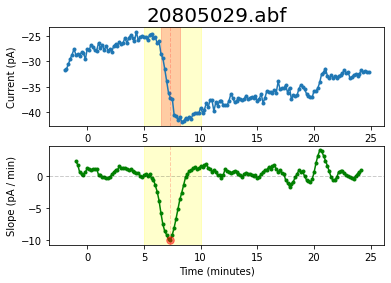

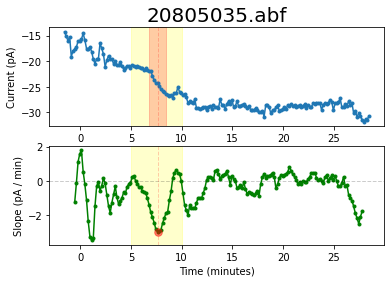

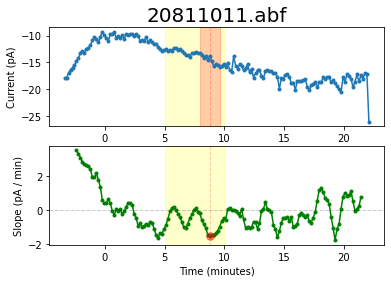

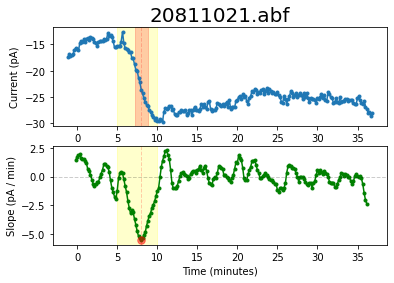

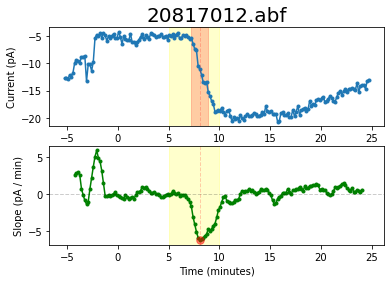

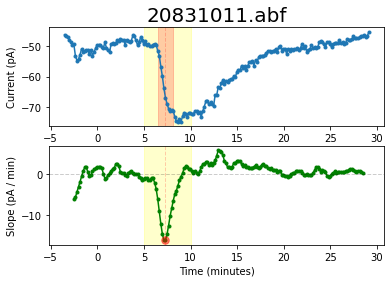

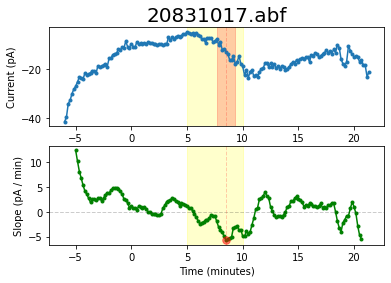

In [6]:
sweepPeriod = 10/60
windowSize = 10
slopesBaseline =[]
slopesDrug =[]
abfIDs = []

for abfFilePath in abfFilePaths:
    # get the tag-aligned raw data of holding current and time
    currentsRaw, timesRaw, abfID = abfTools.meanIhold(abfFilePath)
    abfIDs.append(abfID)
    
    # get slopes of each segments
    currentsSegs = statsTools.getMovingWindowSegments(currentsRaw, windowSize)
    slopes = slopeTools.getAllSegmentSlopes(currentsSegs, sweepPeriod)
    tagTime = abfTools.getFirstTagTime(abfFilePath)
    slopeTimeOffset = windowSize * sweepPeriod / 2-(tagTime-5)
    timesSegs = np.arange(len(slopes))*sweepPeriod + slopeTimeOffset

    # rave function
    slopeBaseline = statsTools.rangeMean(slopes,timesSegs,3,5) # the mean slope between 3-5min was used as the baseline slope
    slopeDrug = statsTools.rangeMin(slopes,timesSegs,5,10) # the minimal slope between 5-10min was used as the drug slope
    slopesBaseline.append(slopeBaseline)
    slopesDrug.append(slopeDrug)

    # find the time point when the minimal slope happens
    indexslopeDrug = slopes.index(slopeDrug)
    peakSlopeTime = timesSegs[indexslopeDrug]
    #print(f"the maximal negative slope is {slopeDrug} at {peakSlopeTime} min (index {indexslopeDrug})")

    # plot current & slope vs time
    plotTools.currentSlopeTimePlot(currentsRaw, timesRaw,slopes,timesSegs,peakSlopeTime, slopeDrug, windowSize, sweepPeriod, abfFilePath)




### Plot slopes before and during drug application

In [ ]:
plotTools.plotPairs(slopesBaseline, slopesDrug)


### Report responders and non-responders based on the change of slope

In [ ]:
responders=[]
nonResponders=[]
for i in range(len(abfIDs)):
    deltaSlope = round(slopesDrug[i]-slopesBaseline[i],3)   # pA / min
    if deltaSlope> responderThreshold:
        nonResponders.append(abfIDs[i])
    else:
        responders.append(abfIDs[i])
responseRate = round(len(responders)/len(abfIDs)*100, 3)
print(f"Responders are: {responders}")
print(f"Non-responders are: {nonResponders}")
print(f"Response rate = {responseRate}%.")